
Dropped columns due to missing values (35):
 - (E)-2-Pentenal Area
 - (E)-Linalool oxide Area
 - 1-Octen-3-ol Area
 - 2-Acetylpyrrole Area
 - 2-Ethylfuran Area
 - 2-Hexanone Area
 - 2-Methylpentan-2-ol Area
 - 2-Pentanol Area
 - 3-Hexanone Area
 - 3-Methyl-2-butanone Area
 - 3-Methyl-3-butenyl acetate Area
 - 6-Methoxyeugenol Area
 - Acetal Area
 - Allyl isothiocyanate Area
 - Butyl acetate Area
 - Butyric acid Area
 - Dihydrocarveol Area
 - Ethyl 2-methylbutyrate Area
 - Ethyl isobutyrate Area
 - Ethyl lactate Area
 - Ethyl vinyl ketone Area
 - Geranyl isovalerate Area
 - Isobutyric acid Area
 - Isopropyl hexanoate Area
 - Methyl 2-methylbutyrate Area
 - Methyl hexanoate Area
 - Methyl isobutyl ketone Area
 - Methyl isovalerate Area
 - Neodihydrocarveol Area
 - Propanoic acid Area
 - Propyl acetate Area
 - Tetrahydrothiophene Area
 - alpha-Pinene Area
 - beta-Pinene Area
 - cis-3-Hexen-1-ol Area
Cross-validated accuracy: 1.000 ± 0.000


/var/folders/_4/f_rgwft14s14_j1xnpz_zn7c0000gn/T/ipykernel_23582/2286442886.py:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')


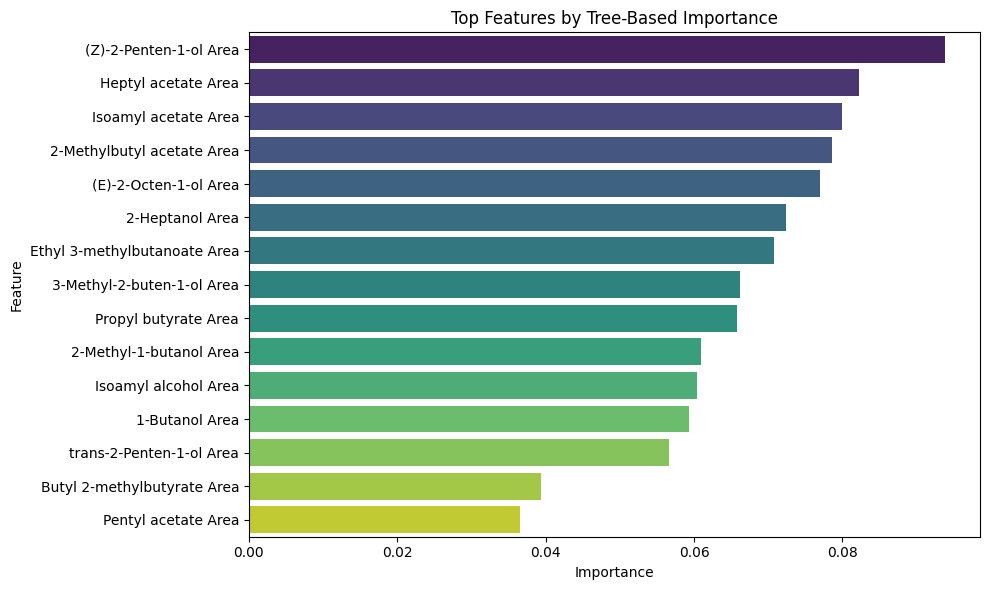

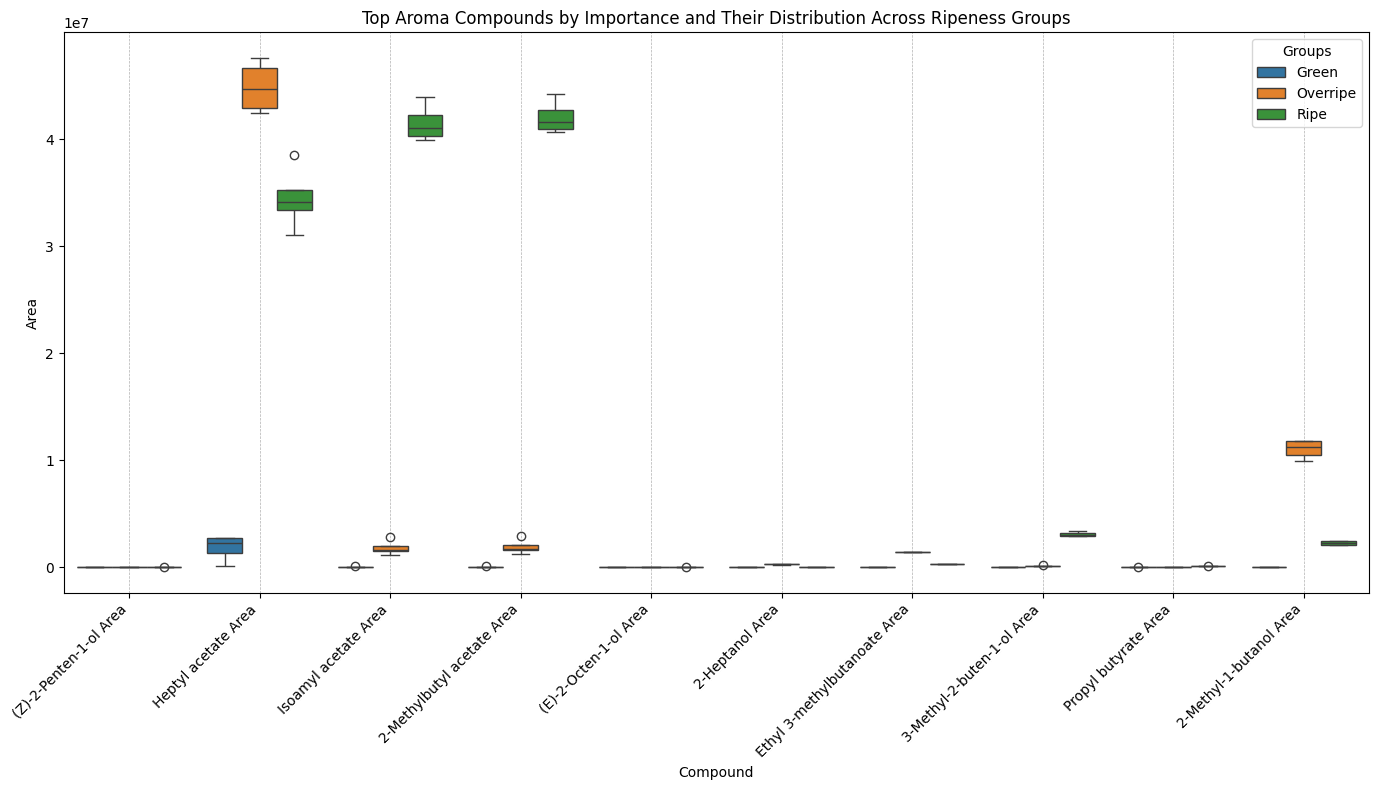


SHAP summary for class: Green


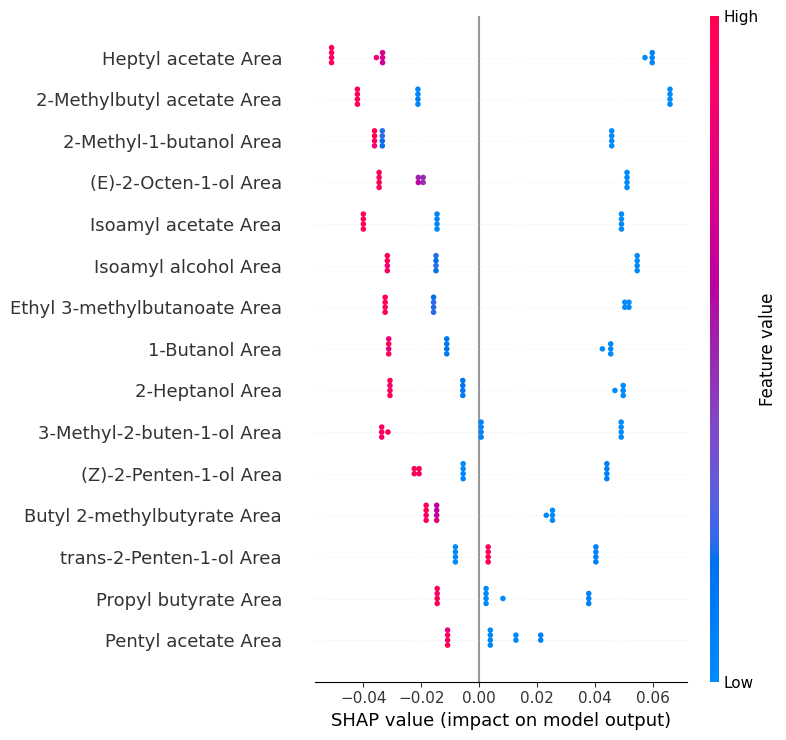


SHAP summary for class: Overripe


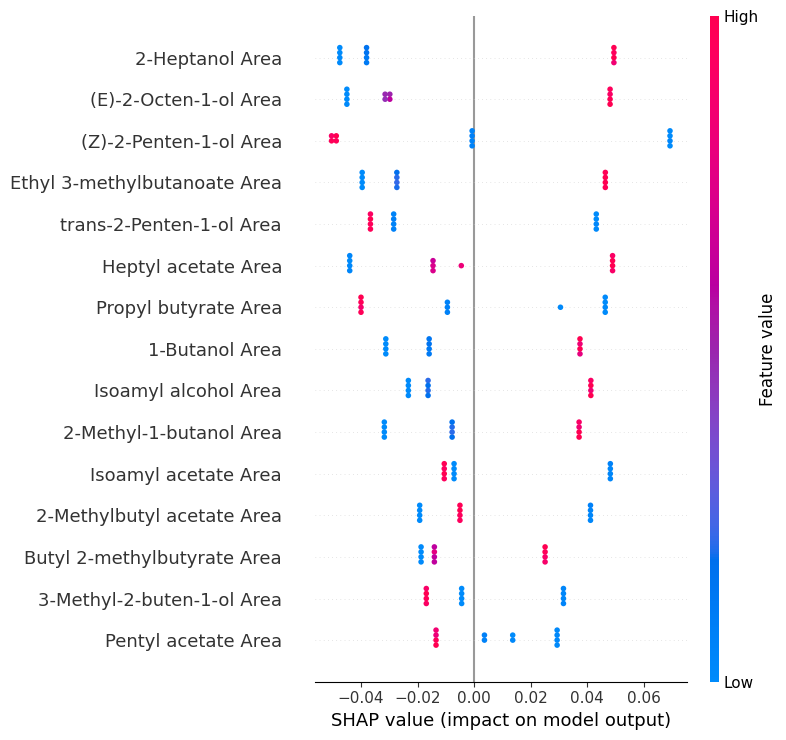


SHAP summary for class: Ripe


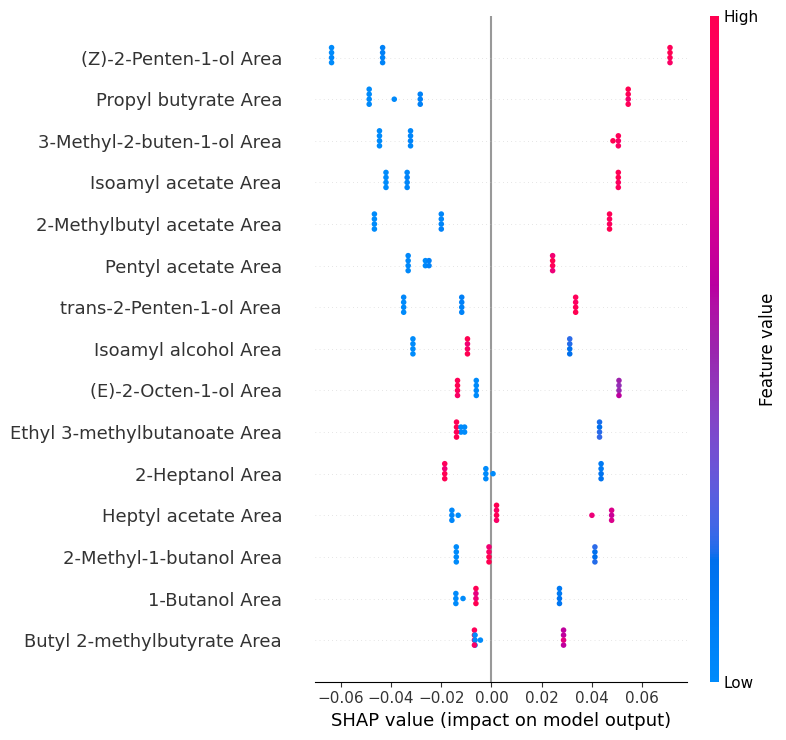

/var/folders/_4/f_rgwft14s14_j1xnpz_zn7c0000gn/T/ipykernel_23582/2286442886.py:133: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(top_features, rotation=45, ha='right')


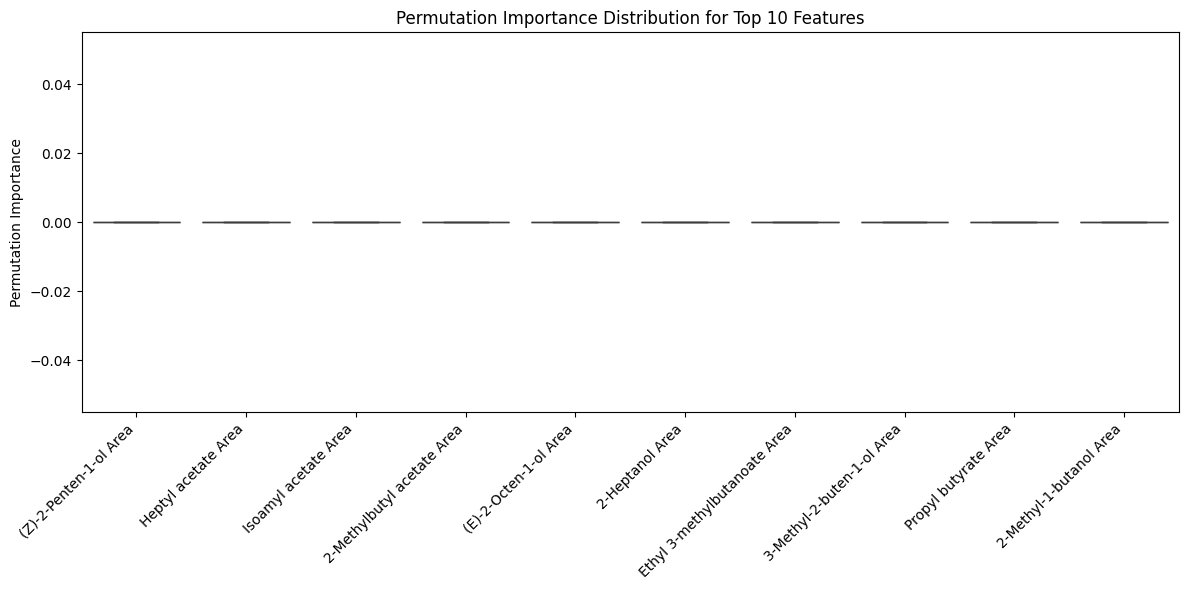


Classification Report (on training data — use CV for generalization estimate):
              precision    recall  f1-score   support

       Green       1.00      1.00      1.00         4
    Overripe       1.00      1.00      1.00         4
        Ripe       1.00      1.00      1.00         4

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12



In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, RepeatedStratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report, confusion_matrix

# ----------------------
# Step 1: Load and clean
# ----------------------

'''
Choice here between filled data or non-filled 
'''
# Load the dataset (group impute, nans filled with pseudocount)
#df = pd.read_csv("badata_imputed_filled.csv")

df = pd.read_csv('badata_imputed.csv') #this one imputes median of category per column if available but has many NaNs
'''
pick the preproces file carefully
'''

df = df.drop(columns=[df.columns[0]])  # Drop index

# Separate labels(y) and features(X)
y_raw = df['Groups']
X_raw = df.drop(columns=['Groups'])

# Identify and drop columns with any missing values
missing_cols = X_raw.columns[X_raw.isna().any()].tolist()
print(f"\nDropped columns due to missing values ({len(missing_cols)}):")
for col in missing_cols:
    print(f" - {col}")

X = X_raw.drop(columns=missing_cols)

# Encode target classes
le = LabelEncoder()
y = le.fit_transform(y_raw)

# -----------------------------
# Step 2: Feature selection
# -----------------------------
# this function uses anova f-test (f_classif) to determine top 15 features that separate classes for decision tree

# this shouldn't be eone before cross val if trying to deploy this model for predictive tasks.
# it's okay in this case as we're using the rf for interpreting data

k = min(15, X.shape[1])  # keep top 15 or fewer
selector = SelectKBest(score_func=f_classif, k=k)
X_selected = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]
X_df = pd.DataFrame(X_selected, columns=selected_features)

# -----------------------------
# Step 3: Train Random Forest
# -----------------------------
# this specifies the random forest model. 
rf = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42)
# stratified k-fold is used so each fold has similar distribution of ripeness.
# uses the repeated version for more valid feature importance 
# (found to not have an effect for this dataset probably as it clusters nicely by categories)
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=10, random_state=42)
scores = cross_val_score(rf, X_df, y, cv=cv)
print(f"Cross-validated accuracy: {scores.mean():.3f} ± {scores.std():.3f}")
rf.fit(X_df, y)

# -----------------------------
# Step 4: Feature Importance
# -----------------------------
importances = rf.feature_importances_
importance_df = pd.DataFrame({'Feature': selected_features, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')
plt.title("Top Features by Tree-Based Importance")
plt.tight_layout()
plt.show()

# -----------------------------
# Step 5: Boxplots by Ripeness Group
# -----------------------------
top_10 = importance_df.head(10)['Feature'].values
df_plot = df[['Groups'] + list(top_10)]
df_melted = df_plot.melt(id_vars='Groups', var_name='Compound', value_name='Area')

plt.figure(figsize=(14, 8))
sns.boxplot(data=df_melted, x='Compound', y='Area', hue='Groups')
plt.xticks(rotation=45, ha='right')
plt.title('Top Aroma Compounds by Importance and Their Distribution Across Ripeness Groups')
plt.tight_layout()
plt.grid(axis='x', linestyle='--', linewidth=0.5)
plt.show()

# -----------------------------
# Step 6: SHAP interpretation
# -----------------------------
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_df)

for class_idx, class_label in enumerate(le.classes_):
    print(f"\nSHAP summary for class: {class_label}")
    shap_class = shap_values[:, :, class_idx]
    shap.summary_plot(shap_class, X_df)

# -----------------------------
# Step 7: Permutation Importance (Robustness check)
# -----------------------------

perm_result = permutation_importance(rf, X_df, y, n_repeats=10, random_state=42)
perm_df = pd.DataFrame({
    'Feature': X_df.columns,
    'Importance': perm_result.importances_mean,
    'Std': perm_result.importances_std
}).sort_values(by='Importance', ascending=False)


# Plot the distribution of importances across permutations for top 10 features
top_features = importance_df.head(10)['Feature'].values
fig, ax = plt.subplots(figsize=(12, 6))

# Plot boxplots of permutation importances
box_data = [perm_result.importances[i] for i in np.argsort(perm_result.importances_mean)[-10:][::-1]]
sns.boxplot(data=box_data)
ax.set_xticklabels(top_features, rotation=45, ha='right')
ax.set_ylabel("Permutation Importance")
ax.set_title("Permutation Importance Distribution for Top 10 Features")
plt.tight_layout()
plt.savefig("permutation_importance_distribution.png")
plt.show()

# -----------------------------
# Step 8: Final Metrics
# -----------------------------
y_pred = rf.predict(X_df)
print("\nClassification Report (on training data — use CV for generalization estimate):")
print(classification_report(y, y_pred, target_names=le.classes_))


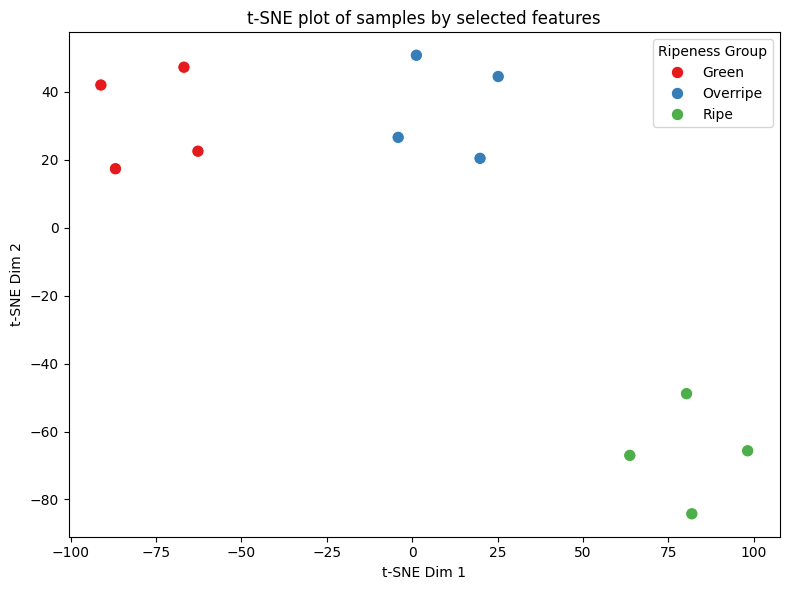

/Users/s/PhD/gitrepo/venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


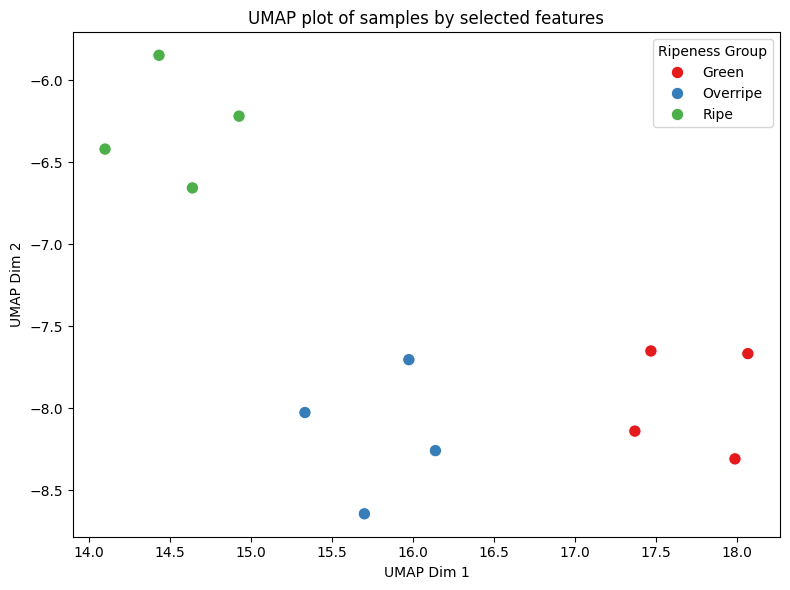

In [4]:
from sklearn.manifold import TSNE
import umap.umap_ as umap  # import UMAP

# -----------------------------
# Step 9: t-SNE visualization
# -----------------------------
tsne = TSNE(n_components=2, random_state=42, perplexity=5, max_iter=1000)
X_tsne = tsne.fit_transform(X_df)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=le.inverse_transform(y), palette='Set1', s=80)
plt.title("t-SNE plot of samples by selected features")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.legend(title="Ripeness Group")
plt.tight_layout()
plt.show()

# -----------------------------
# Step 10: UMAP visualization
# -----------------------------
umap_model = umap.UMAP(n_components=2, random_state=42, n_neighbors=10, min_dist=0.1)
X_umap = umap_model.fit_transform(X_df)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=le.inverse_transform(y), palette='Set1', s=80)
plt.title("UMAP plot of samples by selected features")
plt.xlabel("UMAP Dim 1")
plt.ylabel("UMAP Dim 2")
plt.legend(title="Ripeness Group")
plt.tight_layout()
plt.show()
